# Select features for AAPL

In [2]:
# Импорт стандартных библиотек
import pandas as pd
import numpy as np
import random

import os

# Для разделения данных и предобработки
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Для построения модели LSTM
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization

# Для генетического алгоритма
from deap import base, creator, tools, algorithms

# Для оценки модели
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Для визуализации
import matplotlib.pyplot as plt
%matplotlib inline

# Дополнительные библиотеки
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import joblib

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import Parallel, delayed

#### Выбор наиболее важных признаков на примере AAPL

In [4]:
# Шаг 1: Добавление технических индикаторов

def add_technical_indicators(df):
    # Simple Moving Average (SMA)
    df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
    df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
    
    # Exponential Moving Average (EMA)
    df['EMA_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    delta = df['Adj Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    avg_gain = up.rolling(window=14).mean()
    avg_loss = down.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI_14'] = 100 - (100 / (1 + rs))
    
    # Moving Average Convergence Divergence (MACD)
    ema_12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    
    # Bollinger Bands
    df['BB_upper'] = df['SMA_20'] + 2 * df['Adj Close'].rolling(window=20).std()
    df['BB_lower'] = df['SMA_20'] - 2 * df['Adj Close'].rolling(window=20).std()
    
    # Replace NaN values with zero or forward fill
    df.fillna(method='bfill', inplace=True)
    df.fillna(0, inplace=True)
    
    return df

In [5]:
# Загрузка данных
data = pd.read_csv('data/sp500_train_data.csv')

# Фильтрация данных для тикера AAPL
df = data[data['Ticker'] == 'AAPL'].copy()

# Сортировка по дате
df.sort_values('Date', inplace=True)

# Преобразование столбца Date в datetime
df['Date'] = pd.to_datetime(df['Date'])

In [83]:
# Добавление индикаторов
df = add_technical_indicators(df)

# Создание целевой переменной: доходность на следующий день
df['Return'] = df['Adj Close'].pct_change().shift(-1)

In [85]:
# Удаление строк с NaN
df.dropna(inplace=True)

# Сброс индексов
df.reset_index(drop=True, inplace=True)

In [8]:
# Список признаков (исключая Date, Ticker, Adj Close, Return)
features = df.columns.difference(['Date', 'Ticker', 'Adj Close', 'Return'])

X = df[features]
y = df['Return']

In [9]:
# Объединяем признаки и целевую переменную для расчёта корреляции
corr_df = X.copy()
corr_df['Return'] = y

# Расчёт корреляции
correlation = corr_df.corr()

# Вывод корреляции признаков с целевой переменной
corr_with_target = correlation['Return'].drop('Return')

In [10]:
# Сортировка признаков по абсолютному значению корреляции
corr_with_target = corr_with_target.reindex(corr_with_target.abs().sort_values(ascending=False).index)

print("Корреляция признаков с целевой переменной (Return):")
print(corr_with_target)

Корреляция признаков с целевой переменной (Return):
Close    -0.075371
Open     -0.073677
High     -0.072157
Low      -0.069590
Volume    0.047498
Name: Return, dtype: float64


In [11]:
# Установка порога
threshold = 0.05

# Выбор признаков с абсолютной корреляцией выше порога
selected_features_corr = corr_with_target[abs(corr_with_target) > threshold].index.tolist()

print("Выбранные признаки по анализу корреляции:")
print(selected_features_corr)

Выбранные признаки по анализу корреляции:
['Close', 'Open', 'High', 'Low']


In [12]:
# Разделение данных на обучающую и тестовую выборки
X_rf = X.copy()
y_rf = y.copy()

# Разделение данных (например, 80% на обучение, 20% на тест)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, shuffle=False)

# Обучение модели Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(random_state=42)

In [13]:
# Получение важности признаков
importances = rf_model.feature_importances_
feature_importance = pd.Series(importances, index=X_rf.columns)

# Сортировка признаков по важности
feature_importance = feature_importance.sort_values(ascending=False)

print("Важность признаков по модели Random Forest:")
print(feature_importance)

Важность признаков по модели Random Forest:
Volume    0.384670
Close     0.187233
Open      0.150353
High      0.147552
Low       0.130191
dtype: float64


In [14]:
# Выбор топ-5 признаков
top_n = 5
selected_features_rf = feature_importance.head(top_n).index.tolist()

print(f"Топ-{top_n} признаков по важности:")
print(selected_features_rf)

Топ-5 признаков по важности:
['Volume', 'Close', 'Open', 'High', 'Low']


In [15]:
from sklearn.feature_selection import RFE

# Создание модели RFE
n_features_to_select = 5  # Количество признаков для выбора
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=n_features_to_select)

# Обучение RFE
rfe.fit(X_train_rf, y_train_rf)

RFE(estimator=RandomForestRegressor(random_state=42), n_features_to_select=5)

In [16]:
# Получение маски выбранных признаков
selected_features_rfe = X_rf.columns[rfe.support_].tolist()

print(f"Выбранные признаки с помощью RFE:")
print(selected_features_rfe)

Выбранные признаки с помощью RFE:
['Close', 'High', 'Low', 'Open', 'Volume']


In [135]:
# Объединение признаков, выбранных разными методами
final_selected_features = list(set(selected_features_corr) and set(selected_features_rf) and set(selected_features_rfe))
final_selected_features = ['Adj Close']

print("Окончательный список выбранных признаков:")
print(final_selected_features)

Окончательный список выбранных признаков:
['Adj Close']


In [137]:
# Выбираем данные только с выбранными признаками
X_selected = df[final_selected_features]
y_selected = df['Return']

In [139]:
# Выбираем данные только с выбранными признаками
X_selected = df[final_selected_features]
y_selected = df['Return']

In [141]:
# Выбираем данные только с выбранными признаками
X_selected = df[final_selected_features]
y_selected = df['Return']

In [143]:
# Функция для создания последовательностей
def create_sequences_lstm(X, y, time_steps=30):
    Xs = []
    ys = []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30  # Длина последовательности

X_sequences, y_sequences = create_sequences_lstm(X_selected, y_selected, TIME_STEPS)

In [145]:
# Разделение данных на обучающую и тестовую выборки
split_ratio = 0.8
split_index = int(len(X_sequences) * split_ratio)

X_train_lstm = X_sequences[:split_index]
y_train_lstm = y_sequences[:split_index]
X_test_lstm = X_sequences[split_index:]
y_test_lstm = y_sequences[split_index:]

In [147]:
from sklearn.preprocessing import StandardScaler

# Масштабирование признаков
num_features = X_train_lstm.shape[2]
scalers = {}
for i in range(num_features):
    scalers[i] = StandardScaler()
    X_train_lstm[:, :, i] = scalers[i].fit_transform(X_train_lstm[:, :, i])
    X_test_lstm[:, :, i] = scalers[i].transform(X_test_lstm[:, :, i])

# Масштабирование целевой переменной
scaler_y = StandardScaler()
y_train_lstm = scaler_y.fit_transform(y_train_lstm.reshape(-1, 1)).reshape(-1)
y_test_lstm = scaler_y.transform(y_test_lstm.reshape(-1, 1)).reshape(-1)

In [149]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Построение модели
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Обучение модели
history = model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.8675 - val_loss: 0.3645
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0279 - val_loss: 0.3776
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9420 - val_loss: 0.4049
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2928 - val_loss: 0.3800
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0147 - val_loss: 0.3946
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0507 - val_loss: 0.4248
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0640 - val_loss: 0.3883
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9479 - val_loss: 0.3835
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2118 - val_loss: 0.3726
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0071 - val_loss: 0.4128
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0245 - val_loss: 0.4110
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1701 - val_lo

In [153]:
# Предсказания на тестовой выборке
y_pred_lstm = model.predict(X_test_lstm)

# Обратное преобразование масштаба
y_pred_lstm_inverse = scaler_y.inverse_transform(y_pred_lstm)
y_test_lstm_inverse = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

# Расчёт метрик
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_lstm_inverse, y_pred_lstm_inverse)
mae = mean_absolute_error(y_test_lstm_inverse, y_pred_lstm_inverse)

print(f"MSE: {mse}")
print(f"MAE: {mae}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
MSE: 0.0004745030423105473
MAE: 0.01704790967198108


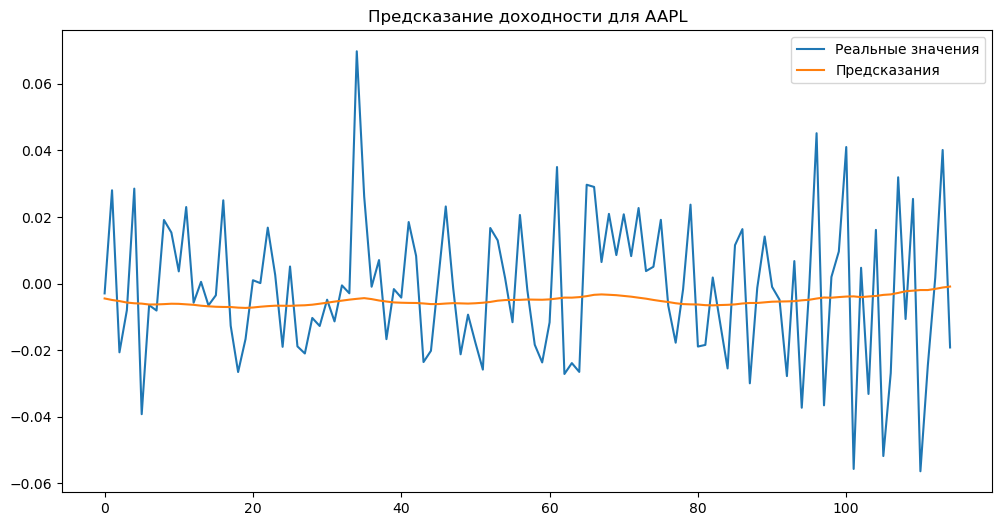

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test_lstm_inverse, label='Реальные значения')
plt.plot(y_pred_lstm_inverse, label='Предсказания')
plt.legend()
plt.title('Предсказание доходности для AAPL')
plt.show()